In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import os, gc
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
glove_file = '../../ml-toolbox-testing/dataset/glove.6B/glove.6B.300d.txt'
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float16')[:1]

embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(glove_file, encoding='latin'))


In [3]:
def build_vocab(texts):
    sentences = texts.progress_apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        if word in embeddings_index:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        elif word.capitalize() in embeddings_index:
            known_words[word] = embeddings_index[word.capitalize()]
            nb_known_words += vocab[word]
        elif word.lower() in embeddings_index:
            known_words[word] = embeddings_index[word.lower()]
            nb_known_words += vocab[word]
        elif word.upper() in embeddings_index:
            known_words[word] = embeddings_index[word.upper()]
            nb_known_words += vocab[word]
        else:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

def vocab_check_coverage(df, col_name):
#     df = pd.concat([train, test]).reset_index(drop=True)
    
    vocab = build_vocab(df[col_name])
    print("Glove : ")
    oov_glove = check_coverage(vocab, embeddings_index)
    oov_glove = {"oov_rate": len(oov_glove) / len(vocab), 'oov_words': oov_glove}
#     print("Paragram : ")
#     oov_paragram = check_coverage(vocab, embed_paragram)
#     oov_paragram = {"oov_rate": len(oov_paragram) / len(vocab), 'oov_words': oov_paragram}
#     print("FastText : ")
#     oov_fasttext = check_coverage(vocab, embed_fasttext)
#     oov_fasttext = {"oov_rate": len(oov_fasttext) / len(vocab), 'oov_words': oov_fasttext}
#     print("Google : ")
#     oov_google = check_coverage(vocab, embed_google)
#     oov_google = {"oov_rate": len(oov_google) / len(vocab), 'oov_words': oov_google}
    
    return oov_glove#, oov_paragram, oov_fasttext


In [4]:
# print("Extracting GloVe embedding")
# for word in list(embeddings_index.keys()):
#     if word is "don't":
#         print("found")


In [5]:
train = pd.read_csv('Dataset/train.csv')
test  = pd.read_csv('Dataset/test.csv')
sub   = pd.read_csv('Dataset/Sample_Submission.csv')

train.shape, test.shape, sub.shape

((5959, 3), (2553, 2), (5, 3))

In [6]:
train.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.rename(columns={'Review Text':'text', 'Review Title':'title'}, inplace=True)
test.columns, train.columns

(Index(['text', 'title'], dtype='object'),
 Index(['text', 'title', 'topic'], dtype='object'))

In [7]:
df = train.append(test, ignore_index=True)
df['text']  = df['text'].str.lower()
df['title'] = df['title'].str.lower()

In [8]:
contraction_mapping = {
    "Trump's" : 'trump is',"'cause": 'because','â€™': "'",',cause': 'because',';cause': 'because',"ain't": 'am not','ain,t': 'am not',
    'ain;t': 'am not','ain´t': 'am not','ain’t': 'am not',"aren't": 'are not','â€“': '-','â€œ':'"',
    'aren,t': 'are not','aren;t': 'are not','aren´t': 'are not','aren’t': 'are not',"can't": 'cannot',"can't've": 'cannot have','can,t': 'cannot','can,t,ve': 'cannot have',
    'can;t': 'cannot','can;t;ve': 'cannot have',
    'can´t': 'cannot','can´t´ve': 'cannot have','can’t': 'cannot','can’t’ve': 'cannot have',
    "could've": 'could have','could,ve': 'could have','could;ve': 'could have',"couldn't": 'could not',"couldn't've": 'could not have','couldn,t': 'could not','couldn,t,ve': 'could not have','couldn;t': 'could not',
    'couldn;t;ve': 'could not have','couldn´t': 'could not',
    'couldn´t´ve': 'could not have','couldn’t': 'could not','couldn’t’ve': 'could not have','could´ve': 'could have',
    'could’ve': 'could have',"didn't": 'did not','didn,t': 'did not','didn;t': 'did not','didn´t': 'did not',
    'didn’t': 'did not',"doesn't": 'does not','doesn,t': 'does not','doesn;t': 'does not','doesn´t': 'does not',
    'doesn’t': 'does not',"don't": 'do not','don,t': 'do not','don;t': 'do not','don´t': 'do not','don’t': 'do not',
    "hadn't": 'had not',"hadn't've": 'had not have','hadn,t': 'had not','hadn,t,ve': 'had not have','hadn;t': 'had not',
    'hadn;t;ve': 'had not have','hadn´t': 'had not','hadn´t´ve': 'had not have','hadn’t': 'had not','hadn’t’ve': 'had not have',"hasn't": 'has not','hasn,t': 'has not','hasn;t': 'has not','hasn´t': 'has not','hasn’t': 'has not',
    "haven't": 'have not','haven,t': 'have not','haven;t': 'have not','haven´t': 'have not','haven’t': 'have not',"he'd": 'he would',
    "he'd've": 'he would have',"he'll": 'he will',
    "he's": 'he is','he,d': 'he would','he,d,ve': 'he would have','he,ll': 'he will','he,s': 'he is','he;d': 'he would',
    'he;d;ve': 'he would have','he;ll': 'he will','he;s': 'he is','he´d': 'he would','he´d´ve': 'he would have','he´ll': 'he will',
    'he´s': 'he is','he’d': 'he would','he’d’ve': 'he would have','he’ll': 'he will','he’s': 'he is',"how'd": 'how did',"how'll": 'how will',
    "how's": 'how is','how,d': 'how did','how,ll': 'how will','how,s': 'how is','how;d': 'how did','how;ll': 'how will',
    'how;s': 'how is','how´d': 'how did','how´ll': 'how will','how´s': 'how is','how’d': 'how did','how’ll': 'how will',
    'how’s': 'how is',"i'd": 'i would',"i'll": 'i will',"i'm": 'i am',"i've": 'i have','i,d': 'i would','i,ll': 'i will',
    'i,m': 'i am','i,ve': 'i have','i;d': 'i would','i;ll': 'i will','i;m': 'i am','i;ve': 'i have',"isn't": 'is not',
    'isn,t': 'is not','isn;t': 'is not','isn´t': 'is not','isn’t': 'is not',"it'd": 'it would',"it'll": 'it will',"It's":'it is',
    "it's": 'it is','it,d': 'it would','it,ll': 'it will','it,s': 'it is','it;d': 'it would','it;ll': 'it will','it;s': 'it is','it´d': 'it would','it´ll': 'it will','it´s': 'it is',
    'it’d': 'it would','it’ll': 'it will','it’s': 'it is',
    'i´d': 'i would','i´ll': 'i will','i´m': 'i am','i´ve': 'i have','i’d': 'i would','i’ll': 'i will','i’m': 'i am',
    'i’ve': 'i have',"let's": 'let us','let,s': 'let us','let;s': 'let us','let´s': 'let us',
    'let’s': 'let us',"ma'am": 'madam','ma,am': 'madam','ma;am': 'madam',"mayn't": 'may not','mayn,t': 'may not','mayn;t': 'may not',
    'mayn´t': 'may not','mayn’t': 'may not','ma´am': 'madam','ma’am': 'madam',"might've": 'might have','might,ve': 'might have','might;ve': 'might have',"mightn't": 'might not','mightn,t': 'might not','mightn;t': 'might not','mightn´t': 'might not',
    'mightn’t': 'might not','might´ve': 'might have','might’ve': 'might have',"must've": 'must have','must,ve': 'must have','must;ve': 'must have',
    "mustn't": 'must not','mustn,t': 'must not','mustn;t': 'must not','mustn´t': 'must not','mustn’t': 'must not','must´ve': 'must have',
    'must’ve': 'must have',"needn't": 'need not','needn,t': 'need not','needn;t': 'need not','needn´t': 'need not','needn’t': 'need not',"oughtn't": 'ought not','oughtn,t': 'ought not','oughtn;t': 'ought not',
    'oughtn´t': 'ought not','oughtn’t': 'ought not',"sha'n't": 'shall not','sha,n,t': 'shall not','sha;n;t': 'shall not',"shan't": 'shall not',
    'shan,t': 'shall not','shan;t': 'shall not','shan´t': 'shall not','shan’t': 'shall not','sha´n´t': 'shall not','sha’n’t': 'shall not',
    "she'd": 'she would',"she'll": 'she will',"she's": 'she is','she,d': 'she would','she,ll': 'she will',
    'she,s': 'she is','she;d': 'she would','she;ll': 'she will','she;s': 'she is','she´d': 'she would','she´ll': 'she will',
    'she´s': 'she is','she’d': 'she would','she’ll': 'she will','she’s': 'she is',"should've": 'should have','should,ve': 'should have','should;ve': 'should have',
    "shouldn't": 'should not','shouldn,t': 'should not','shouldn;t': 'should not','shouldn´t': 'should not','shouldn’t': 'should not','should´ve': 'should have',
    'should’ve': 'should have',"that'd": 'that would',"that's": 'that is','that,d': 'that would','that,s': 'that is','that;d': 'that would',
    'that;s': 'that is','that´d': 'that would','that´s': 'that is','that’d': 'that would','that’s': 'that is',"there'd": 'there had',
    "there's": 'there is','there,d': 'there had','there,s': 'there is','there;d': 'there had','there;s': 'there is',
    'there´d': 'there had','there´s': 'there is','there’d': 'there had','there’s': 'there is',
    "they'd": 'they would',"they'll": 'they will',"they're": 'they are',"they've": 'they have',
    'they,d': 'they would','they,ll': 'they will','they,re': 'they are','they,ve': 'they have','they;d': 'they would','they;ll': 'they will','they;re': 'they are',
    'they;ve': 'they have','they´d': 'they would','they´ll': 'they will','they´re': 'they are','they´ve': 'they have','they’d': 'they would','they’ll': 'they will',
    'they’re': 'they are','they’ve': 'they have',"wasn't": 'was not','wasn,t': 'was not','wasn;t': 'was not','wasn´t': 'was not',
    'wasn’t': 'was not',"we'd": 'we would',"we'll": 'we will',"we're": 'we are',"we've": 'we have','we,d': 'we would','we,ll': 'we will',
    'we,re': 'we are','we,ve': 'we have','we;d': 'we would','we;ll': 'we will','we;re': 'we are','we;ve': 'we have',
    "weren't": 'were not','weren,t': 'were not','weren;t': 'were not','weren´t': 'were not','weren’t': 'were not','we´d': 'we would','we´ll': 'we will',
    'we´re': 'we are','we´ve': 'we have','we’d': 'we would','we’ll': 'we will','we’re': 'we are','we’ve': 'we have',"what'll": 'what will',"what're": 'what are',"what's": 'what is',
    "what've": 'what have','what,ll': 'what will','what,re': 'what are','what,s': 'what is','what,ve': 'what have','what;ll': 'what will','what;re': 'what are',
    'what;s': 'what is','what;ve': 'what have','what´ll': 'what will',
    'what´re': 'what are','what´s': 'what is','what´ve': 'what have','what’ll': 'what will','what’re': 'what are','what’s': 'what is',
    'what’ve': 'what have',"where'd": 'where did',"where's": 'where is','where,d': 'where did','where,s': 'where is','where;d': 'where did',
    'where;s': 'where is','where´d': 'where did','where´s': 'where is','where’d': 'where did','where’s': 'where is',
    "who'll": 'who will',"who's": 'who is','who,ll': 'who will','who,s': 'who is','who;ll': 'who will','who;s': 'who is',
    'who´ll': 'who will','who´s': 'who is','who’ll': 'who will','who’s': 'who is',"won't": 'will not','won,t': 'will not','won;t': 'will not',
    'won´t': 'will not','won’t': 'will not',"wouldn't": 'would not','wouldn,t': 'would not','wouldn;t': 'would not','wouldn´t': 'would not',
    'wouldn’t': 'would not',"you'd": 'you would',"you'll": 'you will',"you're": 'you are','you,d': 'you would','you,ll': 'you will',
    'you,re': 'you are','you;d': 'you would','you;ll': 'you will',
    'you;re': 'you are','you´d': 'you would','you´ll': 'you will','you´re': 'you are','you’d': 'you would','you’ll': 'you will','you’re': 'you are',
    '´cause': 'because','’cause': 'because',"you've": "you have","could'nt": 'could not',
    "havn't": 'have not',"here’s": "here is",'i""m': 'i am',"i'am": 'i am',"i'l": "i will","i'v": 'i have',"wan't": 'want',"was'nt": "was not","who'd": "who would",
    "who're": "who are","who've": "who have","why'd": "why would","would've": "would have","y'all": "you all","y'know": "you know","you.i": "you i",
    "your'e": "you are","arn't": "are not","agains't": "against","c'mon": "common","doens't": "does not",'don""t': "do not","dosen't": "does not",
    "dosn't": "does not","shoudn't": "should not","that'll": "that will","there'll": "there will","there're": "there are",
    "this'll": "this all","u're": "you are", "ya'll": "you all","you'r": "you are","you’ve": "you have","d'int": "did not","did'nt": "did not","din't": "did not","dont't": "do not","gov't": "government",
    "i'ma": "i am","is'nt": "is not","‘I":'I',
    'ᴀɴᴅ':'and','ᴛʜᴇ':'the','ʜᴏᴍᴇ':'home','ᴜᴘ':'up','ʙʏ':'by','ᴀᴛ':'at','…and':'and','civilbeat':'civil beat',\
    'TrumpCare':'Trump care','Trumpcare':'Trump care', 'OBAMAcare':'Obama care','ᴄʜᴇᴄᴋ':'check','ғᴏʀ':'for','ᴛʜɪs':'this','ᴄᴏᴍᴘᴜᴛᴇʀ':'computer',\
    'ᴍᴏɴᴛʜ':'month','ᴡᴏʀᴋɪɴɢ':'working','ᴊᴏʙ':'job','ғʀᴏᴍ':'from','Sᴛᴀʀᴛ':'start','gubmit':'submit','CO₂':'carbon dioxide','ғɪʀsᴛ':'first',\
    'ᴇɴᴅ':'end','ᴄᴀɴ':'can','ʜᴀᴠᴇ':'have','ᴛᴏ':'to','ʟɪɴᴋ':'link','ᴏғ':'of','ʜᴏᴜʀʟʏ':'hourly','ᴡᴇᴇᴋ':'week','ᴇɴᴅ':'end','ᴇxᴛʀᴀ':'extra',\
    'Gʀᴇᴀᴛ':'great','sᴛᴜᴅᴇɴᴛs':'student','sᴛᴀʏ':'stay','ᴍᴏᴍs':'mother','ᴏʀ':'or','ᴀɴʏᴏɴᴇ':'anyone','ɴᴇᴇᴅɪɴɢ':'needing','ᴀɴ':'an','ɪɴᴄᴏᴍᴇ':'income',\
    'ʀᴇʟɪᴀʙʟᴇ':'reliable','ғɪʀsᴛ':'first','ʏᴏᴜʀ':'your','sɪɢɴɪɴɢ':'signing','ʙᴏᴛᴛᴏᴍ':'bottom','ғᴏʟʟᴏᴡɪɴɢ':'following','Mᴀᴋᴇ':'make',\
    'ᴄᴏɴɴᴇᴄᴛɪᴏɴ':'connection','ɪɴᴛᴇʀɴᴇᴛ':'internet','financialpost':'financial post', 'ʜaᴠᴇ':' have ', 'ᴄaɴ':' can ', 'Maᴋᴇ':' make ', 'ʀᴇʟɪaʙʟᴇ':' reliable ', 'ɴᴇᴇᴅ':' need ',
    'ᴏɴʟʏ':' only ', 'ᴇxᴛʀa':' extra ', 'aɴ':' an ', 'aɴʏᴏɴᴇ':' anyone ', 'sᴛaʏ':' stay ', 'Sᴛaʀᴛ':' start', 'SHOPO':'shop',
    }


def correct_contraction(x, dic):
    for word in dic.keys():
        if word in x:
            x = x.replace(word, dic[word])
    return x

df['text']  = df['text'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))
df['title'] = df['title'].progress_apply(lambda x: correct_contraction(x, contraction_mapping))


100%|██████████| 8512/8512 [00:00<00:00, 44913.83it/s]


In [9]:
import os,operator

extra_punct = [
    ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
    '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
    '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
    '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
    '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
    '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
    '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
    'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
    '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
    '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']


import string
my_punct = list(string.punctuation)
all_punct = list(set(my_punct + extra_punct))

special_punc_mappings = {"—": "-", "–": "-", "_": "-", '”': '"', "″": '"', '“': '"', '•': '.', '−': '-',
                         "’": "'", "‘": "'", "´": "'", "`": "'", '\u200b': ' ', '\xa0': ' ','،':'','„':'',
                         '…': ' ... ', '\ufeff': ''}

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:
            text = text.replace(punc, f' {punc} ')
    return text

def clean_special_punctuations(text):
    for punc in special_punc_mappings:
        if punc in text:
            text = text.replace(punc, special_punc_mappings[punc])
    # remove_diacritics don´t' ->  'don t'
    #text = remove_diacritics(text)
    return text



def preprocess(text):
    text = spacing_punctuation(text)
    text = clean_special_punctuations(text)
    return text


df["text"] = df["text"].progress_apply(preprocess)
df['text'] = df['text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['text'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['text'].replace({'  ':' '}, regex=True, inplace=True)

df["title"] = df["title"].progress_apply(preprocess)
df['title'] = df['title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['title'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
df['title'].replace({'  ':' '}, regex=True, inplace=True)


100%|██████████| 8512/8512 [00:00<00:00, 174170.98it/s]


In [10]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)   
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', text)   
    text = re.sub(r'www.[^ ]+', '', text)  
    text = re.sub(r'[a-zA-Z0-9]*www[a-zA-Z0-9]*com[a-zA-Z0-9]*', '', text)  
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = [token for token in text.split() if len(token) > 2]
    text = ' '.join(text)
    return text

df['text']   = df['text'].progress_apply(clean_text)
df['title']  = df['title'].progress_apply(clean_text)

100%|██████████| 8512/8512 [00:00<00:00, 111728.40it/s]


In [11]:
def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

df['text'] = df['text'].progress_apply(clean_text)
df['title'] = df['title'].progress_apply(clean_text)


100%|██████████| 8512/8512 [00:00<00:00, 145592.56it/s]


In [12]:
oov_glove1 = vocab_check_coverage(df, 'text')
oov_glove2 = vocab_check_coverage(df, 'title')


100%|██████████| 8512/8512 [00:00<00:00, 589617.28it/s]

Glove : 
Found embeddings for 92.28% of vocab
Found embeddings for  99.45% of all text
Glove : 
Found embeddings for 94.63% of vocab
Found embeddings for  99.18% of all text


In [13]:
embeddings_index['vanilla']

array([-0.4915], dtype=float16)

In [ ]:
# oov_glove2['oov_words'][:50]


In [ ]:
# def splitting(data):
#     new=[]
#     for sentences in data:
#         yes = sentences.split(". ")
#         new.append(yes) 
#     return new
    
# train['new_text'] = splitting(train['text'])
# test['new_text'] = splitting(test['text'])


# def cleaning1(data):
#     new_text=[]
#     for sentences in data:
#         matching = [s for s in sentences if 'reply posted' not in s]
#         new_text.append(matching)
        
#     return new_text

# train['new_text'] = cleaning1(train['new_text'])
# test['new_text'] = cleaning1(test['new_text'])


# def cleaning2(data):
#     new_text=[]
#     for sentences in data:
#         matching = [s for s in sentences if 'help center' not in s]
#         new_text.append(matching)
        
#     return new_text

# train['new_text'] = cleaning2(train['new_text'])
# test['new_text'] = cleaning2(test['new_text'])


# def cleaning3(data):
#     new_text=[]
    
#     for sentences in data:
#         if(len(sentences)>1):
#             matching = [s for s in sentences if len(s) >= 15]
#             new_text.append(matching)
            
#         else:
#             matching = [s for s in sentences if len(s) >= 2]
#             new_text.append(matching)
        
#     return new_text

# train['new_text'] = cleaning3(train['new_text'])
# test['new_text'] = cleaning3(test['new_text'])

# def don(d):
#     n=[]
#     for s in d:
#         res = ".".join(s)
#         n.append(res)
#     return n

# train['text'] = don(train['new_text'])
# test['text']  = don(test['new_text'])


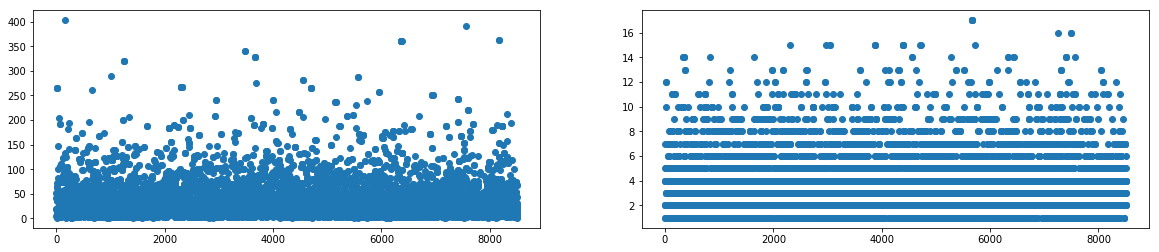

In [14]:
df['wc_text']  = df['text'].apply(lambda x: len(str(x).split(" ")))
df['wc_title'] = df['title'].apply(lambda x: len(str(x).split(" ")))

fig, ax = plt.subplots(1,2,figsize=(20, 4))
ax[0].scatter(range(df.shape[0]), df['wc_text'])
ax[1].scatter(range(df.shape[0]), df['wc_title'])

In [ ]:
# os.makedirs('new_dataset')
# train.to_csv('new_dataset/train1.csv', index=None)
# test.to_csv('new_dataset/test1.csv', index=None)
train.shape, test.shape

In [15]:
def get_quantile(df, col, q1, q2):
    """compute quantile range
    args:
        col: col name
        q1: lower quantile percentile
        q2: upper quantile percentile
    """
    df1 = df[[col]].dropna()
    lower_bound = np.percentile(df1, q=q1)
    upper_bound = np.percentile(df1, q=q2)
    lower_bound = np.round(lower_bound,3)
    upper_bound = np.round(upper_bound, 3)
    min_ = np.round(np.min(df1[col]), 3)
    max_ = np.round(np.max(df1[col]), 3)
    print("Col: {4:<10} min: {0:<10} max: {1:<10} low: {2:<10} high: {3:<10}".format(min_, max_, lower_bound, upper_bound, col))

get_quantile(df, 'wc_text', 1, 95)
get_quantile(df, 'wc_title', 1, 95)

get_quantile(df, 'wc_text', 1, 97)
get_quantile(df, 'wc_title', 1, 97)

get_quantile(df, 'wc_text', 1, 99)
get_quantile(df, 'wc_title', 1, 99)


Col: wc_text    min: 1          max: 403        low: 2.0        high: 119.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 8.0       
Col: wc_text    min: 1          max: 403        low: 2.0        high: 144.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 10.0      
Col: wc_text    min: 1          max: 403        low: 2.0        high: 196.0     
Col: wc_title   min: 1          max: 17         low: 1.0        high: 12.0      


In [16]:
from keras.engine.topology import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints, optimizers, layers
class Attention(Layer):
    def __init__(self, step_dim, W_regularizer=None, b_regularizer=None, W_constraint=None, b_constraint=None, bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias: eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True)+K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


Using TensorFlow backend.


In [ ]:
# from keras.models import Model
# from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
# from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D

# max_features = 50000
# num_classes  = 21
# max_words    = 200
# filter_sizes = [1,2,3,5]
# num_filters  = 36
# inp = Input(shape=(max_words,))
# x = Embedding(max_features, 300, trainable=False)(inp)
# x = Reshape((max_words, 300, 1))(x)
# maxpool_pool = []
# for i in range(len(filter_sizes)):
#     conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], 300),
#                                  kernel_initializer='he_normal', activation='relu')(x)
#     maxpool_pool.append(MaxPool2D(pool_size=(max_words - filter_sizes[i] + 1, 1))(conv))
# z = Concatenate(axis=1)(maxpool_pool)   
# z = Flatten()(z)
# z = Dropout(0.1)(z)
# outp = Dense(num_classes, activation="softmax")(z)
# model = Model(inputs=inp, outputs=outp)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [17]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras import Model

from keras.layers import Bidirectional, CuDNNLSTM, LSTM, CuDNNGRU, GRU, Embedding
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, Flatten, Concatenate
from keras.layers import SpatialDropout1D, Dropout, GlobalMaxPooling1D, MaxPooling1D

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau


In [18]:
len(embeddings_index)

400000

In [19]:
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(list(df['text']))
word_index1 = tokenizer1.word_index

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(list(df['title']))
word_index2 = tokenizer2.word_index

len(word_index1), len(word_index2)

(9387, 2830)

In [20]:
max_features1 = len(word_index1) + 1
max_features2 = len(word_index2) + 1

max_words1 = 200
max_words2 = 17

text = tokenizer1.texts_to_sequences(df['text'])
text = pad_sequences(text, maxlen = max_words1)

title = tokenizer2.texts_to_sequences(df['title'])
title = pad_sequences(title, maxlen = max_words2)

text.shape, title.shape

((8512, 200), (8512, 17))

In [21]:
batch_size   = 32
epochs       = 40
num_classes  = 21


In [23]:
inp1 = Input(shape=(max_words1,))
inp2 = Input(shape=(max_words2,))

x1 = Embedding(max_features1, 300, trainable=True)(inp1)
x2 = Embedding(max_features2, 300, trainable=True)(inp2)

x1 = Bidirectional(LSTM(128, return_sequences=True))(x1)
x1 = Bidirectional(LSTM(64, return_sequences=True))(x1)
x1 = Attention(max_words1)(x1)

x2 = Bidirectional(LSTM(64, return_sequences=True))(x2)
x2 = Bidirectional(LSTM(32, return_sequences=True))(x2)
x2 = Attention(max_words2)(x2)

x1, x2

(<tf.Tensor 'attention_3/Sum_1:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'attention_4/Sum_1:0' shape=(?, 64) dtype=float32>)

In [24]:
x = Concatenate(axis=-1)([x1, x2])
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
modelATT = Model(inputs=[inp1, inp2], outputs=x)
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])
modelATT.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 300)     2816400     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 17, 300)      849300      input_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [25]:
tr_len = train.shape[0]
ts_len = test.shape[0]
# train.shape[0] + test.shape[0], df.shape[0]
train1 = df.iloc[:tr_len]
test1  = df.iloc[tr_len:]
train1.shape, test.shape

((5959, 5), (2553, 2))

In [26]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

cl_map, cl_map_inv = get_mapping(train1, 'topic')

In [27]:
train1['target'] = train1['topic'].astype('category').cat.codes
train1['target'] = train1['target'].astype('int')

text_title = np.concatenate([text, title], axis=1)
tr_text_title = text_title[:tr_len]
ts_text_title = text_title[tr_len:]
print(tr_text_title.shape, ts_text_title.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    tr_text_title, train1['target'], shuffle=True,
    stratify=train1['target'], test_size=0.3, random_state=1337
)
X_train.shape, Y_train.shape

(5959, 217) (2553, 217)


((4171, 217), (4171,))

In [28]:
X_tr_text  = X_train[:,:200]
X_tr_title = X_train[:,200:]

X_ts_text  = X_test[:,:200]
X_ts_title = X_test[:,200:]

X_tr_text.shape, X_tr_title.shape, X_ts_text.shape, X_ts_title.shape 

((4171, 200), (4171, 17), (1788, 200), (1788, 17))

In [29]:
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=num_classes)
Y_test  = to_categorical(Y_test, num_classes=num_classes)
Y_train.shape, Y_test.shape

((4171, 21), (1788, 21))

In [30]:
from sklearn.utils import class_weight
def get_class_weights(y):
    """ 
    Example:
        model.fit(X_t, y, batch_size=10, epochs=2,validation_split=0.1,sample_weight=sample_wts)
    
    """
    return class_weight.compute_sample_weight('balanced', y)

cls_wts = get_class_weights(Y_train)
cls_wts

array([1.60750658e-05, 1.85060810e-05, 1.85060810e-05, ...,
       1.95252374e-05, 1.60750658e-05, 5.45514998e-06])

In [31]:
cls_wts.shape

(4171,)

In [34]:
modelATT.compile(loss='categorical_crossentropy', 
                 optimizer=Adam(lr=1e-2), metrics=['accuracy'])

In [35]:
%%time
early_stop = EarlyStopping(monitor="val_acc", patience=1, verbose=1)
history    = modelATT.fit(
    [X_tr_text, X_tr_title], Y_train,
    validation_data = ([X_ts_text, X_ts_title], Y_test),
    epochs          = epochs,
    batch_size      = batch_size,
    verbose         = 1,
    sample_weight   = cls_wts,
    callbacks       = [early_stop]
)

Train on 4171 samples, validate on 1788 samples
Epoch 1/40
4171/4171 [==============================] - 113s 27ms/step - loss: 8.4009e-05 - acc: 0.0173 - val_loss: 3.0743 - val_acc: 0.0358
Epoch 2/40
4171/4171 [==============================] - 103s 25ms/step - loss: 8.3744e-05 - acc: 0.0254 - val_loss: 3.0808 - val_acc: 0.0229
Epoch 00002: early stopping
CPU times: user 11min 22s, sys: 58.9 s, total: 12min 21s
Wall time: 3min 42s


In [ ]:
import gc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF

def tfidf_feature(train, test, col_name, min_df=3, analyzer='word', 
                  token_pattern=r'\w{1,}', ngram=3, stopwords='english', 
                  n_component=120, decom_flag=False, which_method='svd', 
                  max_features=None):
    """return tfidf feature
    Args:
        train, test: dataframe
        col_name: column name of text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        n_component: n_component of svd feature transform
        decom_flag: Wheteher to run svd/nmf on top of that or not (by default: False)
        which_method: which to run [svd or nmf] on top of tfidf (by default: False)
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Transformed feature space of the text data, as well as tfidf function instance
        if svd_flag== True : train_tf, test_tf, tfv, svd
        else : train_tf, test_tf, tfv
    example:
        train_tfv, test_tfv, tfv = tfidf_feature(X_train, X_test, ['text'], min_df=3)
        train_svd, test_svd, complete_tfv, tfv, svd = tfidf_feature(X_train, X_test, ['text'], 
            min_df=3, svd_component=3, svd_flag=True)

    """
    tfv = TfidfVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, max_df=1.0, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                use_idf=1, smooth_idf=1, sublinear_tf=1,
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
#         return complete_df
#         print(complete_df.shape, complete_df.columns)

    tfv.fit(list(complete_df[:].values))

    if decom_flag is False:
        train_tfv =  tfv.transform(train[col_name].values.ravel()) 
        test_tfv  = tfv.transform(test[col_name].values.ravel())

        del complete_df
        gc.collect()
        return train_tfv, test_tfv, tfv
    else:
        complete_tfv = tfv.transform(complete_df[:].values.ravel())
        
        if which_method is 'svd':
            svd = TruncatedSVD(n_components=n_component)
            svd.fit(complete_tfv)
            complete_dec = svd.transform(complete_tfv)
        else:
            nmf = NMF(n_components=n_component, random_state=1234, alpha=0, l1_ratio=0)
            nmf.fit(complete_tfv)            
            complete_dec = nmf.fit_transform(complete_tfv)            
        
        
        complete_dec = pd.DataFrame(data=complete_dec)
        complete_dec.columns = [which_method+'_'+str(i) for i in range(n_component)]

        train_dec = complete_dec.iloc[:train.shape[0]]
        test_dec = complete_dec.iloc[train.shape[0]:].reset_index(drop=True)

        del complete_dec, complete_df
        gc.collect()
        return train_dec, test_dec, complete_tfv, tfv

def countvect_feature(train, test, col_name, min_df=3, analyzer='word', token_pattern=r'\w{1,}', ngram=3, stopwords='english', max_features=None):
    """return CountVectorizer feature
    Args:
        train, test: dataset
        col_name: columns name of the text feature
        min_df: if Int, then it represent count of the minimum words in corpus (remove very rare word)
        analyzer: [‘word’, ‘char’]
        ngram: max range of ngram
        token_pattern: [using: r'\w{1,}'] [by default: '(?u)\b\w\w+\b']
        stopwords: ['english' or customized by remove specific words]
        max_features: max no of features to keep, based on frequency. It will keep words with higher freq
    return:
        Count feature space of the text data, as well as its function instance
    """
    ctv = CountVectorizer(min_df=min_df,  max_features=max_features, 
                strip_accents='unicode', analyzer=analyzer, 
                token_pattern=token_pattern, ngram_range=(1, ngram), 
                stop_words = stopwords)

    complete_df = pd.concat([train[col_name], test[col_name]], axis=0)
    ctv.fit(list(complete_df[:].values))

    train_tf =  ctv.transform(train[col_name].values.ravel()) 
    test_tf  = ctv.transform(test[col_name].values.ravel())

    del complete_df
    gc.collect()
    return train_tf, test_tf, ctv


In [ ]:
out_tfidfs = []
for ngram in [1,2,3,4,5]:
    out_tfidfs.append(tfidf_feature(train, test, ''))

In [ ]:
out_tfidf1 = tfidf_feature(train, test, 'text', ngram=1)
out_tfidf2 = tfidf_feature(train, test, 'text', ngram=2)
out_tfidf3 = tfidf_feature(train, test, 'text', ngram=3)
out_tfidf4 = tfidf_feature(train, test, 'text', ngram=5)

out_vect1 = countvect_feature(train, test, 'text', ngram=1)
out_vect2 = countvect_feature(train, test, 'text', ngram=2)
out_vect3 = countvect_feature(train, test, 'text', ngram=3)
out_vect4 = countvect_feature(train, test, 'text', ngram=5)

print('tf-idf features: ', out_tfidf1[0].shape, 
     out_tfidf2[0].shape, out_tfidf3[0].shape, out_tfidf4[0].shape)
print('count-vect features: ', out_vect1[0].shape, 
     out_vect2[0].shape, out_vect3[0].shape, out_vect4[0].shape)


## Multinomial bayes classifier

In [ ]:
train['target'] = train['topic'].astype('category').cat.codes
train['target'] = train['target'].astype('int')
all_class = list(train['target'].unique())
print(len(all_class))

In [ ]:
train[train['target'] == 1].shape, out_tfidf1.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, Y_train)
# pred = clf.predict(X_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("tfidf4 : ", clf.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect1 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect2 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect3 : ", clf.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
clf = MultinomialNB().fit(X_train, Y_train)
print("count-vect4 : ", clf.score(X_test, Y_test))


In [ ]:
logistic_reg = LogisticRegression(penalty='l2', dual=False, 
    C=0.01, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
    random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_tfidf4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("tfidf4 : ", logistic_reg.score(X_test, Y_test))

print("=="*25)

from sklearn.naive_bayes import MultinomialNB
X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect1[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect1 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect2[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect2 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect3[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect3 : ", logistic_reg.score(X_test, Y_test))

X_train, X_test, Y_train, Y_test = train_test_split(
    out_vect4[0], train['target'], stratify=train['target'], test_size=0.3
)
logistic_reg.fit(X_train, Y_train)
print("count-vect4 : ", logistic_reg.score(X_test, Y_test))


In [ ]:
sub_df = pd.read_csv('Dataset/Sample_Submission.csv')
sub_df

In [ ]:
logistic_reg.fit(out_vect3[0], train['target'])
pred = logistic_reg.predict(out_vect3[1])
pred.shape

In [ ]:
# def category_encoder(df)
test.drop('topic', axis=1, inplace=True)
test['target'] = pred
test.head()

In [ ]:
test['topic'] = test['target'].apply(lambda x: class_mapping_reverse[str(x)])

In [ ]:
test.drop('target', axis=1, inplace=True)
# os.makedirs('submission')
test.to_csv('submission/linear_model1.csv', index=None)

In [ ]:
def get_mapping(df, col_name):
    cat_codes = df[col_name].astype('category')
    
    class_mapping = {}
    i = 0
    for col in cat_codes.cat.categories:
        class_mapping[col] = i
        i += 1
    
    class_mapping_reverse = {}
    for key, value in class_mapping.items():
        class_mapping_reverse[value] = key

    return class_mapping, class_mapping_reverse

In [ ]:
class_mapping, class_mapping_reverse = get_mapping(train, 'topic')

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

params = {}
params['alpha'] = 1
passive_agg = PassiveAggressiveClassifier(C=params['alpha'], early_stopping=False, validation_fraction=0.3, n_iter_no_change=5, shuffle=True, verbose=0, n_jobs=-1, random_state=1234, loss='hinge', class_weight='balanced', average=False, n_iter=None)
ridge_clf = RidgeClassifier(alpha=params['alpha'], fit_intercept=True, normalize=True, class_weight='balanced', random_state=1234)
logistic_reg = LogisticRegression(penalty='l2', dual=False, C=params['alpha'], fit_intercept=True, intercept_scaling=1, class_weight='balanced', random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)

In [ ]:
ridge_clf.fit(X_train, Y_train)
print(ridge_clf.score(X_test, Y_test))
print("==============")

passive_agg.fit(X_train, Y_train)
print(passive_agg.score(X_test, Y_test))
print("==============")

logistic_reg.fit(X_train, Y_train)
print(logistic_reg.score(X_test, Y_test))
print("==============")


In [ ]:
from sklearn.metrics import f1_score

for alpha in [0.01, 0.1, 0.5, 1, 5, 10]:
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(pred)
#     print(f1_score(ts_y, pred, average='micro', sample_weight=None))
#     print(logistic_reg.score(ts_x, ts_y))
print("==============")

In [ ]:
for alpha in np.linspace(0.0001,0.1,10):
    logistic_reg = LogisticRegression(penalty='l2', dual=False, 
        C=alpha, fit_intercept=True, intercept_scaling=1, class_weight='balanced', 
        random_state=1234, max_iter=100, multi_class='warn', verbose=0, n_jobs=-1)
    logistic_reg.fit(X_train, Y_train)
    pred = logistic_reg.score(X_test, Y_test)
    print(alpha, " : ", pred)

In [ ]:
Usage: plot_document_classification_20newsgroups.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loaded
2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories

Extracting features from the training data using a sparse vectorizer
done in 0.412178s at 9.655MB/s
n_samples: 2034, n_features: 33809

Extracting features from the test data using the same vectorizer
done in 0.351330s at 8.162MB/s
n_samples: 1353, n_features: 33809

================================================================================
Ridge Classifier
________________________________________________________________________________
Training:
RidgeClassifier(solver='sag', tol=0.01)
train time: 0.132s
test time:  0.001s
accuracy:   0.896
dimensionality: 33809
density: 1.000000


================================================================================
Perceptron
________________________________________________________________________________
Training:
Perceptron(max_iter=50)
train time: 0.017s
test time:  0.002s
accuracy:   0.888
dimensionality: 33809
density: 0.255302


================================================================================
Passive-Aggressive
________________________________________________________________________________
Training:
PassiveAggressiveClassifier(max_iter=50)
train time: 0.031s
test time:  0.002s
accuracy:   0.904
dimensionality: 33809
density: 0.694674


================================================================================
kNN
________________________________________________________________________________
Training:
KNeighborsClassifier(n_neighbors=10)
train time: 0.002s
test time:  0.317s
accuracy:   0.858

================================================================================
Random forest
________________________________________________________________________________
Training:
RandomForestClassifier(n_estimators=100)
train time: 1.671s
test time:  0.071s
accuracy:   0.840

================================================================================
L2 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, tol=0.001)
train time: 0.145s
test time:  0.002s
accuracy:   0.900
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50)
train time: 0.030s
test time:  0.002s
accuracy:   0.902
dimensionality: 33809
density: 0.579380


================================================================================
L1 penalty
________________________________________________________________________________
Training:
LinearSVC(dual=False, penalty='l1', tol=0.001)
train time: 0.301s
test time:  0.002s
accuracy:   0.873
dimensionality: 33809
density: 0.005553


________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='l1')
train time: 0.093s
test time:  0.002s
accuracy:   0.887
dimensionality: 33809
density: 0.022901


================================================================================
Elastic-Net penalty
________________________________________________________________________________
Training:
SGDClassifier(max_iter=50, penalty='elasticnet')
train time: 0.252s
test time:  0.002s
accuracy:   0.899
dimensionality: 33809
density: 0.187472


================================================================================
NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training:
NearestCentroid()
train time: 0.004s
test time:  0.002s
accuracy:   0.855

================================================================================
Naive Bayes
________________________________________________________________________________
Training:
MultinomialNB(alpha=0.01)
train time: 0.003s
test time:  0.001s
accuracy:   0.899
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
BernoulliNB(alpha=0.01)
train time: 0.004s
test time:  0.003s
accuracy:   0.884
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training:
ComplementNB(alpha=0.1)
train time: 0.004s
test time:  0.001s
accuracy:   0.911
dimensionality: 33809
density: 1.000000


================================================================================
LinearSVC with L1-based feature selection
________________________________________________________________________________
Training:
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])
train time: 0.252s
test time:  0.002s
accuracy:   0.880

In [ ]:
# tf_train[i] # feature count vector for training case i
# y_train[i] # label for training case i

# The count vectors are defined as:

# p = sum of all feature count vectors with label 1

# p = tf_train[y_train==1].sum(0) + 1

# q = sum of all feature count vectors with label 0

# q = tf_train[y_train==0].sum(0) + 1

# Notice that we add 1 to both count vectors to ensure that every token appear at least one time in each class.

# The log-count ratio r is:

# r = np.log((p/p.sum()) / (q/q.sum()))

# And b:

# b = np.log(len(p) / len(q))

# Just the ratio of number of positive and negative training cases.

In [ ]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test).mean()

In [ ]:
out_tfidf1[0][train['target'] == 5].sum(0)

In [ ]:
out_tfidf1[0][train['target'] == 4].sum(0)

In [ ]:
np.sum(np.equal(out_tfidf1[0][train['target'] == 5].sum(0), 
                out_tfidf1[0][train['target'] == 3].sum(0)))

In [ ]:
out_tfidf1[0][train['target'] == 5].shape

In [ ]:
out_tfidf1[0][train['target'] == 2].shape

In [ ]:
idx = train[train['target'] == 2].index

In [ ]:
out_tfidf1[0][idx].sum(0)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts):
    output = []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output

# train['text1'] = train['text'].progress_apply(lemmatization)
# test['text1']  = test['text'].progress_apply(lemmatization)


In [ ]:
df = train.append(test, ignore_index=True)
df['text1'] = df['text'].apply(lemmatization)

In [ ]:
df[:5]['text'].apply(lemmatization)

In [ ]:
df1

In [ ]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]



In [ ]:
df1['text'].apply(lemmatize_text)

In [ ]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(text):
    return []
    for i in texts:
        s = [token.lemma_ for token in nlp(i)]
        output.append(' '.join(s))
    return output


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [ ]:
# word_tokenize(df1['text'][4])

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer

porter=PorterStemmer()
porter.stem('helping')

In [ ]:
for word in df1['text'][1].split(" "):
    print(porter.stem(word))

In [ ]:
import gc
del df1, df
gc.collect()

In [ ]:
df = train.append(test, ignore_index=True)
df.shape

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

cv = CountVectorizer(max_df=0.95,min_df=2,stop_words='english')
term_matrix = cv.fit_transform(df['text'])
# print(term_matrix)

In [ ]:
lda = LatentDirichletAllocation(n_components=5, n_jobs=4)
lda.fit(term_matrix)


In [ ]:
gc.collect()

In [ ]:
lda.components_[0]

In [ ]:
topic = lda.components_[0]
top_words_indices = topic.argsort()[-10:]
for index in top_words_indices:
    print(cv.get_feature_names()[index])

In [ ]:
topic_word_dict = {}
for index,topic in enumerate(lda.components_):
    words = [cv.get_feature_names()[i] for i in topic.argsort()[-10:]]
    topic_word_dict[index] = words
    print('Top words for topic {}'.format(index))
    print(words)
    print('-'*120)


In [ ]:

topics = lda.transform(term_matrix)
data['topic'] = topics.argmax(axis=1)


def assign_topics(row):
    topic = row['topic']
    words = topic_word_dict[topic]

    return words


data['topic words'] = data.apply(assign_topics,axis=1)
print(data.head())

